### Group 8
- Nimrod Grandpierre
- Jonas Riber Jørgensen
- Johan Ulstrup
- Laura Fur

# Project 4: Tree Comparison

This project is about comparing evolutionary trees constructed using the Neighbor Joining (NJ) methods on different datasets. The objective is to implement an efficient algorithm for computing the RF distance between two trees and use this implementation in an experiment.

## <span style="color:cornflowerblue">Problem<span/>

You should implement an algorithm for computing the RF distance between two unrooted evolutionary trees over the same set of species. The algorithm can e.g. be Day's algorithm as explained in class. You should make a program called ```rfdist``` which as input takes two evolutionary trees in Newick format (also referred to as 'New Hampshire format'), and outputs the RF distance between them.

The archive testdata.zip contains two trees with RF-distance 8. These can e.g. be used for testing.

In [1]:
from Bio import Phylo
import random
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from simulate_trees import *

### **Implementation**

In [2]:
def rfdist(T1: object, T2: object) -> int:
    
    """ Part 1: Rooting the trees """

    # Default root is the first sequence in tree 1 that is also found in tree 2.
    # Assumption: at least one sequence is shared between the two trees.
    
    seqNames_T1 = np.array([leaf.name for leaf in T1.get_terminals()])
    seqNames_T2 = np.array([leaf.name for leaf in T2.get_terminals()])

    rootName = None
    for i in seqNames_T1:
        if i in seqNames_T2:
            rootName = i
            break
    
    # Root trees with selected root:
    T1.root_with_outgroup(rootName)
    T2.root_with_outgroup(rootName)

    """ Part 2: Depth-first numbering """

    # Empty dictionary used for depth-first numbering tree 1:
    numberingDict = {leaf: 0 for leaf in seqNames_T1}

    # Depth-first numbering of tree 1:
    T1_labeller = 1
    for leaf in T1.get_terminals():
        if leaf.name != rootName:
            numberingDict[leaf.name] = T1_labeller
            leaf.name = T1_labeller
        T1_labeller += 1

    # Depth-first numbering of tree 2:
    T2_labeller = len(numberingDict) + 1
    for leaf in T2.get_terminals():
        if leaf.name != rootName:
            if leaf.name in numberingDict.keys(): 
                leaf.name = numberingDict[leaf.name]
            else: 
                leaf.name = T2_labeller # In case tree 2 has sequences not present in tree 1, we also label those.
                T2_labeller += 1

    """ Part 3: Identifying tree branches """

    def get_branches(DF_tree: object) -> list[tuple]:
        branch_intervals = []

        # Depth-first search:
        def dfs(node):
            if node.is_terminal():
                return np.array([node.name])
                
            else:
                left_interval = dfs(node.clades[0])
                right_interval = dfs(node.clades[1])
                interval = (left_interval[0], right_interval[-1]) # [-1], because we might have intervals containing more than two values and want to get the last.
                branch_intervals.append(interval)

                return interval

        # Initialization: start traversal at the children of the root:
        for child in DF_tree.root.clades:
            _ = dfs(child)

        return branch_intervals

    branches_T1 = np.array(get_branches(T1))
    branches_T2 = np.array(get_branches(T2))

    """ Part 4: Calculating the RF distance """

    common_branches = set(map(tuple, branches_T1)).intersection(map(tuple, branches_T2))
    RF_distance = len(branches_T1) + len(branches_T2) - 2 * len(common_branches)

    return RF_distance

#### ```rfdist()```

The function consists of four main parts:

**1. Rooting the unrooted input trees.** The input trees are read using the ```read()``` function from the Phylo module. When selecting a root, it is assumed that at least one sequence is shared between the two trees. The default root is the first sequence in tree 1 that is also found in tree 2, when traversing the trees.

**2. Depth-first numbering.** The names of all sequences present in the first tree are inserted in a dictionary and numbered in the order they are inserted. The sequences in the second tree are also labeled based on the values in the dictionary given to the sequences common between the two trees. In case tree 2 contains other sequences than those found in tree 1, they are also labeled accordingly, counting from the last number labeled to a sequence in tree 1.

**3. Identifying tree branches.** Here, we identify branches and label them as intervals, based on the depth-first numbering labels. Two nested functions are used for this.

- The ```get_branches()``` function takes a rooted, depth-first-numbered tree as input and calls a depth-first search helper function. It uses the helper function's output to make a list for which a list with branch interval labels from a single tree.

- The depth-first search helper function, ```dfs()``` takes a recursive approach and returns an interval for each node, which is a tuple of the smallest and largest labels (from the depth-first numbering) found in the subtree rooted at that node. The interval for the root node is not included, as it doesn't define a branch in the tree.

**4. Calculating the RF distance** based on the branches identified and labeled in part 3. First, each list of branches is converted into a set of tuples. ```map``` converts each branch into a tuple, such that ```set``` can be used to remove duplicate branches, as this function ensures uniqueness of elements and only takes tuples. ```set.intersection()``` finds the common elements between the two sets of tuples, giving the set of common branches between the two trees. The RF distance is then calculated from the following formula: 

**<span style='color:lightskyblue'>RF distance = (number of branches in T1 not in T2) + (number of branches in T2 not in T1) - 2 * (number of common branches between T1 and T2)<span/>**

 Counting the number of bipartitions (branches) that are present in one tree but not the other, and vice versa. By subtracting twice the number of common branches from the sum of the number of branches in both trees, it ensures that common branches are not counted twice in the final distance.

## <span style="color:cornflowerblue">Tests<span/>
The function seems to work as intended, judging from running the algorithm on the provided test data:

In [3]:
tree1 = Phylo.read('Testdata/tree1.new', 'newick')
tree2 = Phylo.read('Testdata/tree2.new', 'newick')

print(f'RF distance: {rfdist(tree1, tree2)}')

RF distance: 8


#### **Time complexity analysis of** ```rfdist()```
Simulating trees of different sizes - the largest tree containing 1000 sequences - in Newick format (see simulate_trees.py file for script):

In [4]:
random.seed(8)

for i in ['treeA', 'treeB']:
    for tree_len in range(2, 1001):
        tree = generate_tree(tree_len, set())
        write_newick(tree, f'Testdata/RandomTrees/{i}_len_{tree_len}.new')

Measuring running time

In [5]:
treeA_list = sorted([file for file in os.listdir('Testdata/RandomTrees') if file.startswith('treeA')], key=lambda s: int(s.split('_')[2].split('.')[0]))
treeB_list = sorted([file for file in os.listdir('Testdata/RandomTrees') if file.startswith('treeB')], key=lambda s: int(s.split('_')[2].split('.')[0]))

tree_sizes = np.arange(2, 1001)
exec_times = np.zeros(len(tree_sizes))

for i in range(2, len(tree_sizes)):
    treeA = Phylo.read(f'Testdata/RandomTrees/{treeA_list[i]}', 'newick')
    treeB = Phylo.read(f'Testdata/RandomTrees/{treeB_list[i]}', 'newick')

    start_time = time.time()

    rfdist(treeA, treeB)

    end_time = time.time()
    exec_times[i] = end_time - start_time

In [6]:
df = pd.DataFrame({'tree_size': tree_sizes, 'exec_time': exec_times})

lower_exec = df[df['exec_time'] < 0.03]
upper_exec = df[df['exec_time'] > 0.03]

lower_size = lower_exec['tree_size']
upper_size = upper_exec['tree_size']

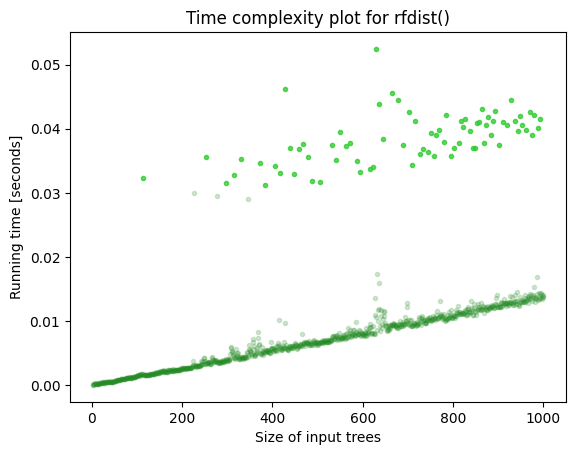

In [7]:
plt.scatter(lower_size, lower_exec['exec_time'], color = 'forestgreen', marker = '.', alpha = 0.2)
plt.scatter(upper_size, upper_exec['exec_time'], color = 'limegreen', marker = '.', alpha = 0.8)
plt.xlabel('Size of input trees')
plt.ylabel('Running time [seconds]')
plt.title('Time complexity plot for rfdist()')
plt.grid(False)
plt.show()

>From the above time complexity plot, it is confirmed that the algorithm runs in $O(n)$ (at least for trees containing 2-1000 sequences), as expected. Both 'scatter clouds' are approximately linear. The fact that we observe _two_ 'scatter clouds' could indicate that the running time is also dependent on how different the trees are - i.e., how many sequences they share, relative to their size and due to memory allocation. However, this difference in running time can be considered negligible, looking at the y axis. Data is simple enough that we do not see a steep increase in running time.

>**NOTE**: the time complexity is only analyzed for when the two trees have the same number of sequences.

## <span style="color:cornflowerblue">Experiments<span/>
The programs QuickTree and RapidNJ are implementations of the NJ methods. QuickTree implements the basic cubic time algorithm while RapidNJ implements an algorithm the is faster in practice. You might want to take a look at the QuickTree paper and the RapidNJ paper.

Downloading quicktree_2.0.tar.gz and rapidnj-src-2.3.3.zip and compiling on a Linux-platform is straightforward (just run 'make'). 

The file patbase_aibtas.fasta contains 395 protein sequences from the P-Type ATPase Database in Fasta-format.

You should make an experiment where you first construct a number of trees for these 395 sequences using NJ (as implemented in QuickTree and RapidNJ) based on different multiple alignments of the 395 sequences, and secondly, compare the construted trees using your program rfdist in order to investigate the influence of using different multiple alignment methods and tree reconstruction methods. Biologically, the 395 sequences are grouped into five groups. The group which a sequenence belongs to is indicated by the first character (1-5) in its name in Fasta-file. If you visualize your constructed trees using e.g. the program Dendroscope, you might want to inspect to what extend sequences from one group are in the same subtree.

The alignment methods you most use are:

- Clustal Omega: https://www.ebi.ac.uk/jdispatcher/msa/clustalo
- Kalign: https://www.ebi.ac.uk/jdispatcher/msa/kalign
- MUSCLE: https://www.ebi.ac.uk/jdispatcher/msa/muscle

You should use the default parameters of each program. Beware of the output format. QuickTree can only read multiple alignments in Stockholm-format, and RapidNJ can read multiple alignments in both Fasta- and single line Stockholm-format.

Converting to Stockholm-format: You can use the online converter available at http://hcv.lanl.gov/content/sequence/FORMAT_CONVERSION/form.html to convert different alignment formats to Stockholm- and Fasta-format. To convert to single line Stockholm-format, you must set the 'Output line width' to 'as wide as possible'. Update (Apr 2021): It seems that QuickTree 2.0 cannot read the Stockholm-format produced by the online converter. The problem is that the Stockholm-file constructed by the online converter starts with the line "# STOCKHOLM 1.0" follow by an empty line. If you remove these two lines, then QuickTree 2.0 can read the file. I do not know when this "bug" was introduced, but it used to work ;-)

### **Experiment 1**
*For each alignment method (Clustal Omega, Kalign, MUSCLE), you build a NJ tree using QuickTree and RapidNJ, and compute the RF-distance between each combination of these six trees. The outcome of your experiment, is an 6x6 table showing the RF-distance between each pair of constructed trees. (You might want to use the program Dendroscope to visualize the constructed trees.)*

In [8]:
tree_list = sorted([file for file in os.listdir('alignments') if file.endswith('.newick')], key=lambda s: sum(map(ord, s)))

rfdists = [[0] * len(tree_list) for _ in range(len(tree_list))]

for i, treeA_file in enumerate(tree_list):
    for j, treeB_file in enumerate(tree_list):
        if i != j:
            treeA = Phylo.read(f'alignments/{treeA_file}', 'newick')
            treeB = Phylo.read(f'alignments/{treeB_file}', 'newick')
            rfdists[i][j] = rfdist(treeA, treeB)

labels = [file[:-7] for file in tree_list]
pd.DataFrame(rfdists, index = labels, columns = labels)

,kalign.rapidNJ,muscle.rapidnj,clustal.rapidnj,kalign.quicktree,muscle.quicktree,clustal.quicktree
kalign.rapidNJ,0,402,382,428,458,464
muscle.rapidnj,412,0,402,538,368,400
clustal.rapidnj,404,394,0,496,402,362
kalign.quicktree,424,534,494,0,510,474
muscle.quicktree,446,368,400,510,0,334
clustal.quicktree,456,430,356,480,336,0


>The alignment files generated with the alignment tools, Clustal Omega, Kalign and MUSCLE, can be found in the alignments permuted folder, respectively. Additionally the trees generated in newick format can be found in the alignments_results and permuted_results folders. 

### **Experiment 2**
*Redo the above experiment where you use 395 input sequences in patbase_aibtas_permuted.fasta. This yields another 6x6 table.*

In [9]:
tree_list = sorted([file for file in os.listdir('permuted/permuted_results') if file.endswith('.newick')], key=lambda s: sum(map(ord, s)))

num_trees = len(tree_list)
rfdists = [[0] * num_trees for _ in range(num_trees)]

for i, treeA_file in enumerate(tree_list):
    for j, treeB_file in enumerate(tree_list):
        if i != j:
            treeA = Phylo.read(f'permuted/permuted_results/{treeA_file}', 'newick')
            treeB = Phylo.read(f'permuted/permuted_results/{treeB_file}', 'newick')
            rfdists[i][j] = rfdist(treeA, treeB)

labels = [file[:-7] for file in tree_list]
pd.DataFrame(rfdists, index = labels, columns = labels)

,kalign.permuted.rapidnj,muscle.permuted.rapidnj,clustal.permuted.rapidnj,kalign.permuted.quicktree,muscle.permuted.quicktree,clustal.permuted.quicktree
kalign.permuted.rapidnj,0,408,392,430,458,428
muscle.permuted.rapidnj,412,0,388,496,380,418
clustal.permuted.rapidnj,396,390,0,496,414,366
kalign.permuted.quicktree,430,494,496,0,500,458
muscle.permuted.quicktree,460,382,416,498,0,342
clustal.permuted.quicktree,430,428,368,458,344,0


### **Experiment 3**
*Compute the RF-distance between the trees produced in 'Experiment 1' and 'Experiment 2' using the same alignment and tree reconstruction method. This yields 6 distances.*

In [10]:
nonpermuted = sorted([file for file in os.listdir('alignments') if file.endswith('.newick')], key=lambda s: sum(map(ord, s)))
permuted = sorted([file for file in os.listdir('permuted/permuted_results') if file.endswith('.newick')], key=lambda s: sum(map(ord, s)))

rfdists = []

for i in range(len(nonpermuted)):
    treeA = Phylo.read(f'alignments/{nonpermuted[i]}', 'newick')
    treeB = Phylo.read(f'permuted/permuted_results/{permuted[i]}', 'newick')
    rfdists.append(rfdist(treeA, treeB))

labels = [file[:-7] for file in nonpermuted]
pd.DataFrame([rfdists], index = ['RF distance'], columns = labels)

,kalign.rapidNJ,muscle.rapidnj,clustal.rapidnj,kalign.quicktree,muscle.quicktree,clustal.quicktree
RF distance,584,498,466,628,402,414


## <span style='color:cornflowerblue'>Conclusion<span/>
>We have successfully implemented the ```rfdist()``` function in Python and conducted the experiments outlined in the project description.  